# Graph Neural Network + LSTM for Spatio-temporal data analysis
In this notebook, we want to integrate Graph Neural Network with Neural Network with memory (like RNN or GRU) in order to encode both spatial and temporal information in one neural structure.
Particularly, we apply this network to learn how phenomena change over time.

## Dependencies
In the following I will use:
- pytorch: as the main framework for auto grad and neural network definition
- torc-geometric-temporal: pytorch extension for combining GNN and RNN

In [1]:
!conda install pyg -c pyg -y
!conda install -c conda-forge pygraphviz -y
!pip install torch-geometric-temporal
!pip install class-resolver

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::jupyter==1.0.0=py39hf3d152e_7
  - conda-forge/noarch::qtconsole-base==5.3.2=pyha770c72_0
  - conda-forge/noarch::ipywidgets==8.0.1=pyhd8ed1ab_0
  - conda-forge/noarch::ipython==8.4.0=pyh41d4057_1
  - conda-forge/noarch::ipykernel==6.15.2=pyh210e3f2_0
  - conda-forge/noarch::notebook==6.4.12=pyha770c72_0
  - conda-forge/noarch::jupyter_console==6.4.4=pyhd8ed1ab_0
  - conda-forge/noarch::qtconsole==5.3.2=pyhd8ed1ab_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/gianluca/anaconda3/envs/gnn-forecast

  added / updated specs:
    - pyg


The following packages will be downloaded:

    package                    |          

### Packages import

In [2]:
## Utilities
import json
import os
import colorsys
import math
import numpy as np
## Pytorch
import torch_geometric
from torch_geometric.data import Data
from torch import Tensor, LongTensor
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU
## Render
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import networkx as nx

## Convert Data
The data are generated using [Alchemist simulations]().
In this case, each simulation exports an entire snapshot for each time unit.
Each snapshot is a JSON array that expresses the group of node as a graph. Particularly, the representation is an Array composed by:
   1. Array of node (i.e., feature extracted point-wise)
   2. Array of link, described as `[id_starting_node, id_ending_node, weight]`

A single file, contains several snapshot (one for each timestamp).
Therefore, a representation an entire file could be described as: $S_1, ..., S_n$
where $S_i$ is $((N_1, ..., N_n), (E_1,  ..., E_k))$
$N_i$ is the feature of the node i (id), in this case is a single double value. We extracted the position too, but only for the rendering part
$E_i$ is a triple that contains: $(ID, ID, W)$
So, first of all, we load all the data in `graph_data`

In [3]:
files = os.listdir("data/raw")
data_size = 10
split = 0.8
graph_data = []
for file_name in files[:data_size]:
    file = open("data/raw/" + file_name)
    graph_data.append(json.load(file))
    file.close()

PyTorch use a simple representation to describe graph.
There should be a tensor for node features, with a shape `[num_nodes, num_nodes_features]`
Then, the connectivity is expressed through [COO format](https://scipy-lectures.org/advanced/scipy_sparse/coo_matrix.html), with a shape of `[2, num_edge]`.
The idea is that, the tensor should be as:
```
[
    [start_id_a, start_id_b, start_id_c]
    [end_id_a, end_id_b, end_id_c]
]
```
Then, you can also express the weight for each link as tensor with the shape of: `[num_edges, num_link_features]`
Finally, you can add the target value (y) that should have an arbitrary shape.
`covert_json_to_data` get the Alchemist representation and transforms it in a PyTorch representation ([PyTorch Data]()).

In [4]:
def convert_json_to_data(json):
    def convert_single_time_stamp(json):
        x = Tensor(json[0]).reshape((len(json[0]), 3))
        edge_info = np.array(json[1])
        edge_index = LongTensor(edge_info[:, :2]).t()
        edge_data = Tensor(edge_info[:, 2:])
        return Data(x=x, edge_index=edge_index, edge_attr=edge_data)
    return [convert_single_time_stamp(snapshot) for snapshot in json]

`torch_graph_data_position` contains all the information extracted from the Alchemist in form of PyTorch Data graphs

In [5]:
torch_graph_data_position = [convert_json_to_data(graph) for graph in graph_data]

For training and inference purpose, we remove the position from the features set with `remove_position_in_graph`

In [6]:
def remove_position_in_graph(torch_graph_data_position):
    torch_graph_data = []
    for snapshots in torch_graph_data_position:
        flatten_snapshot = []
        for snapshot in snapshots:
            flatten_snapshot.append(
                Data(snapshot.x[:, 0:1], edge_index=snapshot.edge_index, edge_attr=snapshot.edge_attr)
            )
        torch_graph_data.append(flatten_snapshot)
    return torch_graph_data

The dataset is split in training and test with a fixed cut (80% for training and 20% for test)

In [7]:
torch_graph_data = remove_position_in_graph(torch_graph_data_position)
split_index = int(data_size * split)
torch_graph_train = torch_graph_data[:split_index]
torch_graph_test = torch_graph_data[split_index:]

## Graph drawing
`draw_graph` is a utility used to showing the graph structure as the one produced in Alchemist.
Particularly, it takes the series of snapshot of one simulation and produces the graph structure using the position specified in the configuration.
Therefore, you have to use the plain data, not the one "flatten".

In [8]:
def draw_graph(graph, i, ax=None):
    selected_graph = graph[i]
    G = torch_geometric.utils.to_networkx(selected_graph, to_undirected=True)
    color_map = []
    pos = { id: (data[1].item(), data[2].item()) for (id, data) in enumerate(selected_graph.x) }
    max_color = max([selected_graph.x[node][0]] for node in G)[0]
    for node in G:
        color_map.append(colorsys.hsv_to_rgb(selected_graph.x[node][0] / max_color, 1, 1))
    nx.draw(
        G,
        node_size=10,
        node_color=color_map,
        pos=pos,
        ax=ax
    )

You can use the `draw_graph` to show more graphs

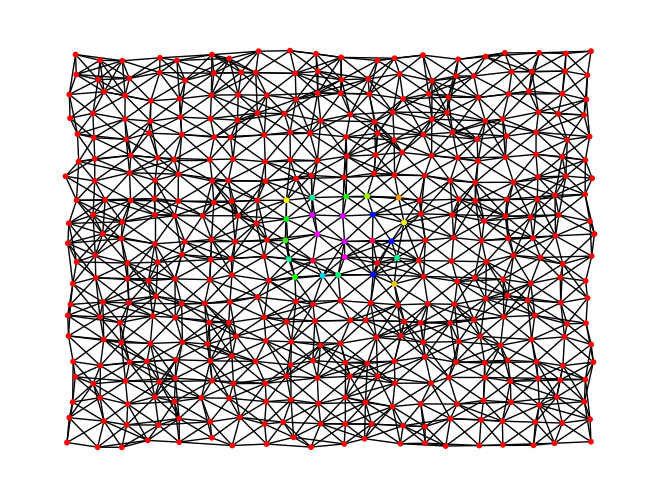

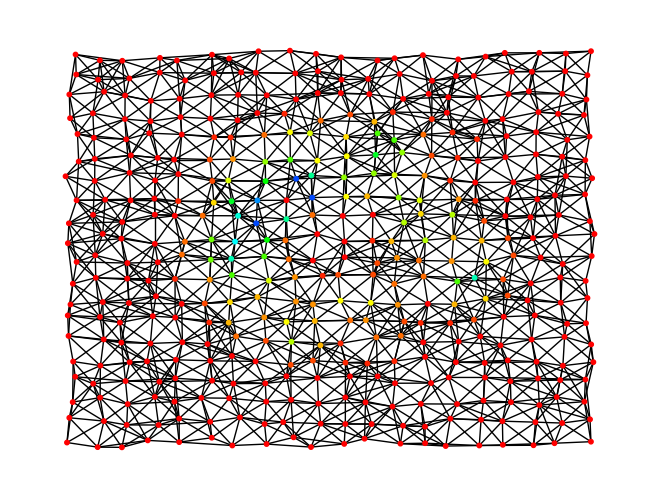

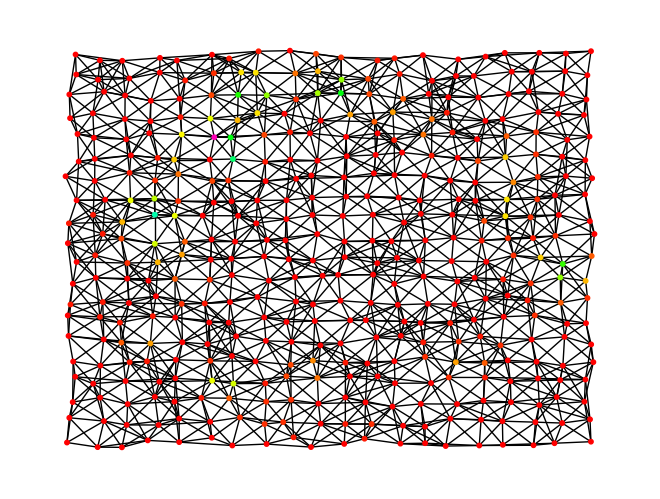

In [11]:
draw_graph(torch_graph_data_position[0], 0)
plt.show()
draw_graph(torch_graph_data_position[0], 50)
plt.show()
draw_graph(torch_graph_data_position[0], 100)

## Model definition
In order to analise the spatio-temporal model, we use a GNN + RNN as a main neural model.
In this case, the PyTorch Geometric Temporal library is used for integrating spatio-temporal model in a PyTorch network.

In [12]:
## Simple network
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        ## K=1 => No Hop, only memory. K=2 => One hop
        self.recurrent = GConvGRU(node_features, 64, K=1) #GConvGRU(node_features, 64, K=2) ## One hop
        self.linear = torch.nn.Linear(64, 1)
    def forward(self, x, edge_index, edge_weight, memory=None):
        memory = self.recurrent(x, edge_index, edge_weight, memory)
        h = F.relu(memory)
        h = self.linear(h)
        return h, memory

In [13]:
model = RecurrentGCN(node_features = 1)

You can load the weight from one of the best previous training

In [15]:
weight = torch.load("data/model-best-so-far")
model.load_state_dict(weight)

<All keys matched successfully>

## Training Phase
Currently, the learning process is mainly sequential.
For each time step, we evaluate the error as:
$cost_t+1 = cost_t + mean((F(G_t) - (G_t+1))^2)$
For each step, the network maintains the memory of the previous evaluations, therefore, for now, each simulation should be iterated completely until the end.
TODO:
- add batches
- better logging
- add validation set
- use window to simplify the training process

In [16]:
### Clean (optional)
import gc
del torch_graph_data_position
del graph_data
del torch_graph_data
gc.collect()

2432

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
model.train()
training_bar = tqdm(range(10))
for epoch in training_bar:
    const_for_epoch = 0
    for simulation in torch_graph_train[:5]:
        h = None
        cost = 0
        for (index, snapshot) in enumerate(simulation[:-1]):
            (y_hat, h) = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h)
            grad = torch.mean((y_hat-simulation[index + 1].x)**2)
            cost = cost + grad
        cost = cost / len(simulation)
        const_for_epoch += cost
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    training_bar.write("Error at %d is %f" % (epoch, const_for_epoch))

  0%|          | 0/10 [00:00<?, ?it/s]

Error at 0 is 30.125795
Error at 1 is 11.883825
Error at 2 is 8.393337
Error at 3 is 6.878577
Error at 4 is 5.834556
Error at 5 is 5.345673
Error at 6 is 4.752679
Error at 7 is 4.488986
Error at 8 is 4.374708
Error at 9 is 4.393703


After training, you can store the model to reuse in other scenario (in our case, we use the model in Alchemist for instance).

In [133]:
torch.save(model.state_dict(), "./data/model-best-so-far")
print(model.state_dict())
torch.save(model, "./data/complete-best-so-far")

OrderedDict([('spatio.lin_rel.weight', tensor([[-0.9401],
        [-0.5676],
        [-0.2845],
        [-0.8217],
        [-0.8631],
        [ 0.3111],
        [ 0.6171],
        [-0.7833]])), ('spatio.lin_rel.bias', tensor([ 0.0425,  0.5862, -0.1933,  0.0160, -0.3941,  0.4148, -0.7185,  0.6432])), ('spatio.lin_root.weight', tensor([[-0.5024],
        [-0.8602],
        [ 1.1684],
        [-0.7887],
        [-0.8219],
        [ 2.6188],
        [-2.4185],
        [-0.1825]])), ('temporal.weight_ih_l0', tensor([[-0.3326,  0.2038,  0.0587, -0.0860, -0.0066,  0.1903,  0.3078,  0.0535,
          0.0046,  0.1509, -0.1755, -0.2178,  0.1554,  0.3227, -0.3291, -0.0613,
         -0.1283, -0.0886,  0.1327, -0.2238, -0.0749,  0.2425,  0.0765,  0.2332,
          0.3325,  0.2200, -0.2508,  0.3214,  0.3458,  0.1104,  0.1223,  0.1920],
        [ 0.0048, -0.0721,  0.1772, -0.3064, -0.2671, -0.3370, -0.3223,  0.2213,
         -0.0923,  0.0831,  0.1329,  0.2455, -0.1087,  0.2803,  0.2937, -0.1948,
    

## Evaluation
The model is verified using the data extracted from other simulation. We verify if the prediction of the next step are coherent with the real one.
Particularly, for each simulation we store the entire graph data after a pass of the neural network.
We also compute the cost as the training phase.
`evaluation_pass` devises how to evaluate the performance for an entire simulation data collected

In [23]:
def evaluation_pass(snapshosts, model, memory_adjust=None):
    cost = 0
    center = memory_adjust
    trajectory = []
    h = None
    for (index, snapshot) in enumerate(snapshosts[:-1]):
        x = snapshot.x
        #if(center != None): ## To check if everything is ok with the spatial notion
        #   x_center = snapshot.x[center]
        #   x = torch.zeros(snapshot.x.shape)
        #   x[center] = x_center
        (y_hat, h) = model(x, snapshot.edge_index, snapshot.edge_attr, h)
        if(center != None and h != None):
            zeros = torch.zeros(h.shape)
            zeros[center] = h[center]
            h = zeros
        cost = cost + torch.mean((y_hat-snapshosts[index+1].x)**2)
        trajectory.append(y_hat)
    return cost / len(test_simulation), trajectory

Then, for each simulation, we extract the cost and the trajectory computed by `evaluation_pass`

In [36]:
model.eval()
total_cost = 0
trajectories = []
for (trajectory_index, test_simulation) in enumerate(torch_graph_test):
    (cost, trajectory) = evaluation_pass(test_simulation, model)
    trajectories.append(trajectory)
    total_cost = cost + total_cost
total_cost = total_cost.item()
print("MSE: {:.4f}".format(total_cost))

MSE: 1.4418


`trajectory_for` is used to extract the time series for a certain sensor in the network.

In [37]:
def trajectory_for(reference, sensor_index):
    return [graph[sensor_index][0].item() for graph in reference]

Constants used to check the result of the learning process.
- `start` and `end` are the timestamps of interest
- `node` is the ID of the node that we wanna evaluated
- `test_index` is the ID of the file that we wanna verify

In [38]:
## Range of interest
start, end = (150, 250)
## Node of interest
node = 150
## Test index of the several simulation tested
test_index = 0

Prepare the data for the plotting part of the selected sensor.

In [39]:
test = torch_graph_test[test_index][1:]
ground_truth = [graph.x for graph in test[start:end]]
perception = [graph.x for graph in torch_graph_test[0][start:end]]
computed = trajectory_for(trajectories[test_index][start:end], node)
perception_trajectory = trajectory_for(perception, node)
y = trajectory_for(ground_truth, node)

Plot the output of the neural network (blue line), the ground truth (orange line) and the value of the current time stamp (green line).

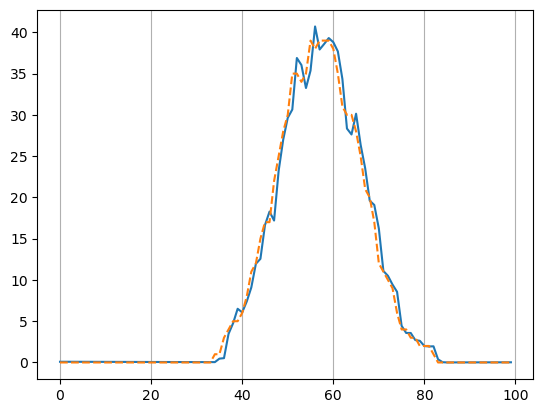

In [43]:
plt.plot(computed)
plt.grid(axis='x')
plt.plot(y, linestyle='dashed')
#plt.plot(perception_trajectory, linestyle='-.')

## 1-hop Neighborhood Test
In this notebook section, I verify if the neural network could work even if the node perceive only the neighborhood.
Therefore:
1 - I normalize the data set extracting only the information of one node (edge, neighborhood node features, and links weight).

In [44]:
mapping = {}
test_reference = torch_graph_test[test_index]
sub_graph = [] ## The result of the "cutting" graph considering only the view of one node.
for element in test_reference:
    indexes = np.array(element.edge_index) ## get of indexes in the adjacency matrix.
    filter_on_attr, start_link, end_link = [], [], []
    ## collect all the node that are neighbors of the one selected
    for (index, link) in enumerate(np.transpose(indexes)):
        if link[0] == node or link[1] == node:
            filter_on_attr.append(index)
            start_link.append(link[0])
            end_link.append(link[1])
    nodes = start_link + end_link ## neighborhood list (with duplicates)
    new_edge_attr = element.edge_attr[filter_on_attr] ## get all edge weight
    nodes = dict(dict.fromkeys(nodes)) ## neighborhood set
    new_x = element.x[list(nodes)] ## extract all the neighbourhood features
    nodes = dict(enumerate(nodes)) ## create a map index -> ID (index is the new ID in the subgraph)
    mapping = dict(map(reversed, nodes.items())) ## map ID -> index (used to map the adjacency matrix)
    flat = lambda elements: [ mapping[element] for element in elements ]
    new_index = LongTensor([flat(start_link), flat(end_link)])
    sub_graph.append(Data(x=new_x, edge_index=new_index, edge_attr=new_edge_attr))

Check that the result match the performance with the global view.

In [45]:
model.eval()
(cost, trajectory) = evaluation_pass(sub_graph, model, mapping[node])
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 32.9780


Prepare for plotting (as in the previous step)

In [46]:
mapped_node = mapping[node]
test = sub_graph[1:]
ground_truth = [graph.x for graph in test[start:end]]
perception = [graph.x for graph in sub_graph[start:end]]
computed = trajectory_for(trajectory[start:end], mapped_node)
perception_trajectory = trajectory_for(perception, mapped_node)
y = trajectory_for(ground_truth, mapped_node)

Effectively plot the result

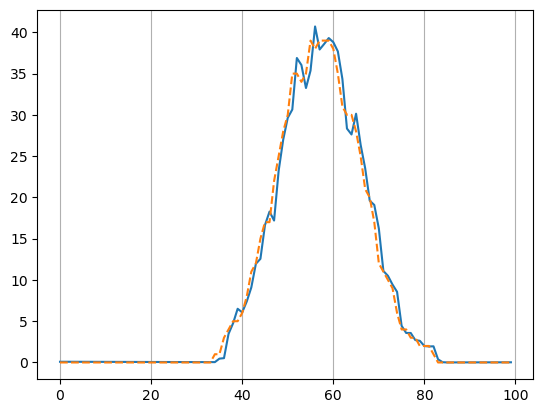

In [47]:
plt.plot(computed)
plt.grid(axis='x')
plt.plot(y, linestyle='dashed')
#plt.plot(perception_trajectory, linestyle='-.')
